## Level 1: Unit sales of all products, aggregated for all stores/states

In [1]:
import os
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator


SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )
data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

In [3]:
data.sort_values(["ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [4]:
scale_factor = np.sqrt(np.nanmean(data.y.diff(1)**2))
scale_factor

5926.012712033271

***

In [5]:
# 4 july features
events_features = make_time_range("2011-01-29", "2016-06-19", "D")
# --
events_features["prev_4july_day"] = 0
events_features.loc[events_features.query("ds.dt.month == 7 & ds.dt.day == 3").index, "prev_4july_day"] = 1
# -- 
events_features["4july_day"] = 0 
events_features.loc[events_features.query("ds.dt.month == 7 & ds.dt.day == 4").index, "4july_day"] = 1

In [6]:
data = pd.merge(data, events_features, how="left", on="ds")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 1912
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 1913 non-null   datetime64[ns]
 1   y                  1913 non-null   int64         
 2   event_name_1       1913 non-null   int8          
 3   lw_type            1913 non-null   int8          
 4   lw_day             1913 non-null   int8          
 5   prev_lw            1913 non-null   int8          
 6   post_lw            1913 non-null   int8          
 7   prev_christmas     1913 non-null   int8          
 8   post_christmas     1913 non-null   int8          
 9   prev_thanksgiving  1913 non-null   int8          
 10  prev_4july_day     1913 non-null   int64         
 11  4july_day          1913 non-null   int64         
dtypes: datetime64[ns](1), int64(3), int8(8)
memory usage: 89.7 KB


***

In [5]:
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

***

In [6]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [7]:
valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods

[(Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')),
 (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')),
 (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')),
 (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')),
 (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')),
 (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')),
 (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')),
 (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')),
 (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')),
 (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')),
 (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')),
 (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')),
 (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [8]:
model_params = {
    'objective': 'l2', 
    'metric': 'rmse', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'seed': 23, 
    'learning_rate': 0.19630674759801756, 
    'num_leaves': 9, 
    'max_bin': 63,
    'feature_fraction': 0.6000000000000001, 
    'bagging_fraction': 0.8, 
    'min_data_in_leaf': 4, 
    'min_gain_to_split': 100000, 
    'lambda_l2': 1.4298908229733496
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{"event_name_1":"default"},
    "copy":True,
}

In [9]:
# 4+ years of history
train_history = 1800

***

In [10]:
#for year in [2011, 2012, 2013, 2014, 2015]:
#    df = data.query(f"'{year}-06-01' <= ds <= '{year}-06-30'")
#    plt.figure(figsize=(15,10))
#    plt.plot_date(df.ds, df.y, "o-", label=f"{year}")
#    plt.grid()
#    plt.legend(loc="best")
#    plt.show()

***

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1067.25it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2390.34
[50]	valid_0's rmse: 2004.78
[75]	valid_0's rmse: 1926.7
[100]	valid_0's rmse: 1947.76
[125]	valid_0's rmse: 1910.59
[150]	valid_0's rmse: 1854.64
[175]	valid_0's rmse: 1887.77
[200]	valid_0's rmse: 1854.73
[225]	valid_0's rmse: 1796.94
[250]	valid_0's rmse: 1752.76
[275]	valid_0's rmse: 1706.1
[300]	valid_0's rmse: 1707.23
[325]	valid_0's rmse: 1718.93
[350]	valid_0's rmse: 1696.64
[375]	valid_0's rmse: 1626.05
[400]	valid_0's rmse: 1585.3
[425]	valid_0's rmse: 1590.67
[450]	valid_0's rmse: 1571.31
[475]	valid_0's rmse: 1577.97
[500]	valid_0's rmse: 1592.76
[525]	valid_0's rmse: 1603.28
[550]	valid_0's rmse: 1606.56
[575]	valid_0's rmse: 1594.47
[600]	valid_0's rmse: 1591.68
[625]	valid_0's rmse: 1595.52
[650]	valid_0's rmse: 1584.81
[675]	valid_0's rmse: 1594.72
[700]	valid_0's rmse: 1576.41
[725]	valid_0's rmse: 1553.89
[750]	valid_0's rmse: 1613.05
[775]	valid_0's rmse: 1631.08
[800]	valid_0'

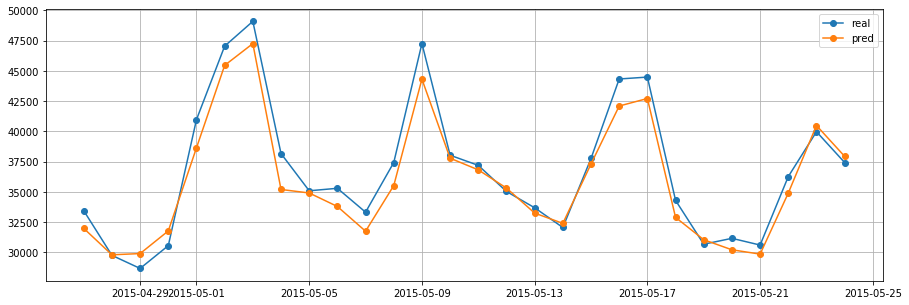

############################################### 2/13 ###############################################
##### Validation period: (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2001.10it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2649.5
[50]	valid_0's rmse: 2439.12
[75]	valid_0's rmse: 2309.38
[100]	valid_0's rmse: 2216.77
[125]	valid_0's rmse: 2186.71
[150]	valid_0's rmse: 2187.4
[175]	valid_0's rmse: 2161.5
[200]	valid_0's rmse: 2155.58
[225]	valid_0's rmse: 2154.16
[250]	valid_0's rmse: 2144.52
[275]	valid_0's rmse: 2138.16
[300]	valid_0's rmse: 2140.61
[325]	valid_0's rmse: 2124.18
[350]	valid_0's rmse: 2118.17
[375]	valid_0's rmse: 2113.24
[400]	valid_0's rmse: 2107.64
[425]	valid_0's rmse: 2129.04
[450]	valid_0's rmse: 2121.21
[475]	valid_0's rmse: 2110.48
[500]	valid_0's rmse: 2119.23
[525]	valid_0's rmse: 2117.53
[550]	valid_0's rmse: 2118.51
[575]	valid_0's rmse: 2108.22
[600]	valid_0's rmse: 2104.64
[625]	valid_0's rmse: 2100.13
[650]	valid_0's rmse: 2107.81
[675]	valid_0's rmse: 2114.06
[700]	valid_0's rmse: 2103.4
[725]	valid_0's rmse: 2107.25
[750]	valid_0's rmse: 2104.7
[775]	valid_0's rmse: 2105.88
[800]	valid_0's 

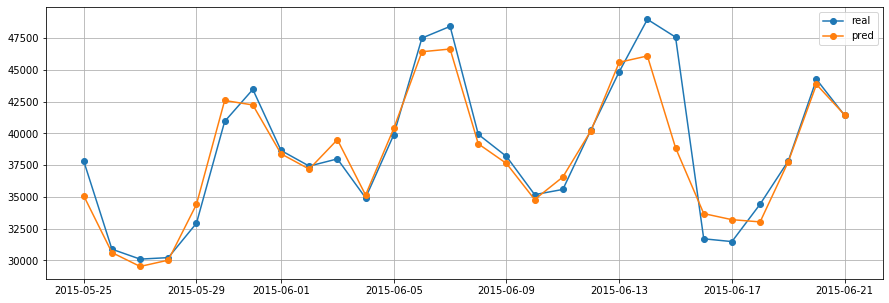

############################################### 3/13 ###############################################
##### Validation period: (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1776.49it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3032.39
[50]	valid_0's rmse: 2705.52
[75]	valid_0's rmse: 2491.62
[100]	valid_0's rmse: 2411
[125]	valid_0's rmse: 2326.95
[150]	valid_0's rmse: 2243.1
[175]	valid_0's rmse: 2233.65
[200]	valid_0's rmse: 2190.06
[225]	valid_0's rmse: 2139.31
[250]	valid_0's rmse: 2056.77
[275]	valid_0's rmse: 2079.19
[300]	valid_0's rmse: 2061.9
[325]	valid_0's rmse: 2080.03
[350]	valid_0's rmse: 2074
[375]	valid_0's rmse: 2065.41
[400]	valid_0's rmse: 2099.08
[425]	valid_0's rmse: 2082.27
[450]	valid_0's rmse: 2083.34
[475]	valid_0's rmse: 2031.77
[500]	valid_0's rmse: 2047.96
[525]	valid_0's rmse: 2053.99
[550]	valid_0's rmse: 2051.56
[575]	valid_0's rmse: 2093.8
[600]	valid_0's rmse: 2062.88
[625]	valid_0's rmse: 2090.87
[650]	valid_0's rmse: 2059.95
[675]	valid_0's rmse: 2061.94
[700]	valid_0's rmse: 2036.48
[725]	valid_0's rmse: 2036.9
[750]	valid_0's rmse: 2072.49
[775]	valid_0's rmse: 2088.05
[800]	valid_0's rmse:

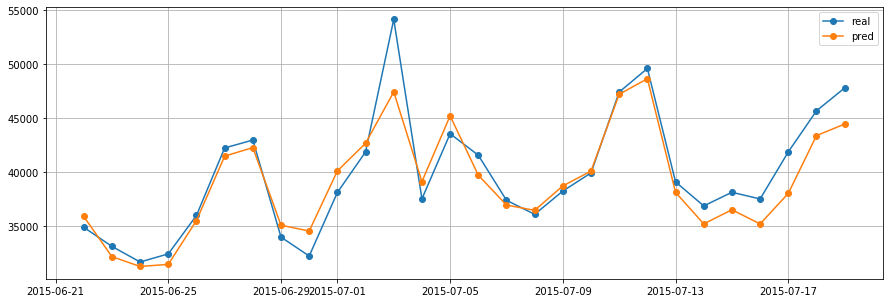

############################################### 4/13 ###############################################
##### Validation period: (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1263.34it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2074.35
[50]	valid_0's rmse: 1820.42
[75]	valid_0's rmse: 1734.37
[100]	valid_0's rmse: 1732.86
[125]	valid_0's rmse: 1619.17
[150]	valid_0's rmse: 1517.63
[175]	valid_0's rmse: 1433.74
[200]	valid_0's rmse: 1410.34
[225]	valid_0's rmse: 1325.44
[250]	valid_0's rmse: 1321.18
[275]	valid_0's rmse: 1305.88
[300]	valid_0's rmse: 1282.15
[325]	valid_0's rmse: 1195.09
[350]	valid_0's rmse: 1150.26
[375]	valid_0's rmse: 1107.83
[400]	valid_0's rmse: 1098.86
[425]	valid_0's rmse: 1114.97
[450]	valid_0's rmse: 1107.63
[475]	valid_0's rmse: 1091.8
[500]	valid_0's rmse: 1050.37
[525]	valid_0's rmse: 1030.86
[550]	valid_0's rmse: 1020.05
[575]	valid_0's rmse: 1024.63
[600]	valid_0's rmse: 1029.73
[625]	valid_0's rmse: 1012.55
[650]	valid_0's rmse: 1006.08
[675]	valid_0's rmse: 1012.68
[700]	valid_0's rmse: 976.947
[725]	valid_0's rmse: 968.764
[750]	valid_0's rmse: 951.416
[775]	valid_0's rmse: 960.993
[800]	valid_

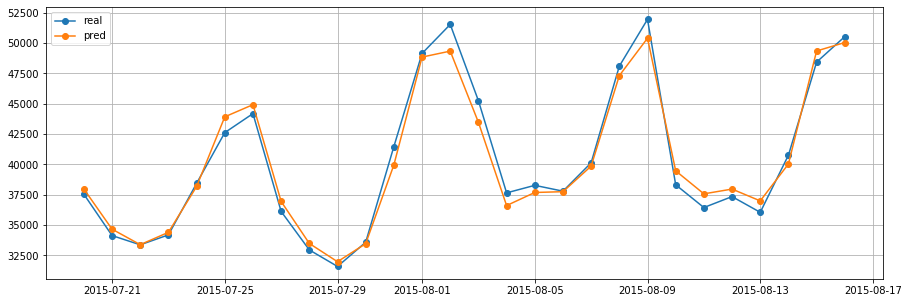

############################################### 5/13 ###############################################
##### Validation period: (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1726.76it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 1795.32
[50]	valid_0's rmse: 1468.12
[75]	valid_0's rmse: 1345.8
[100]	valid_0's rmse: 1373.38
[125]	valid_0's rmse: 1360.13
[150]	valid_0's rmse: 1320.52
[175]	valid_0's rmse: 1332.26
[200]	valid_0's rmse: 1347.33
[225]	valid_0's rmse: 1384.95
[250]	valid_0's rmse: 1381.34
[275]	valid_0's rmse: 1419.46
[300]	valid_0's rmse: 1394.29
[325]	valid_0's rmse: 1384.08
[350]	valid_0's rmse: 1387.92
[375]	valid_0's rmse: 1411.56
[400]	valid_0's rmse: 1402.23
[425]	valid_0's rmse: 1404.25
Early stopping, best iteration is:
[143]	valid_0's rmse: 1314.02
RMSE: 1314.023647815792
RMSSE: 0.22173824317783788


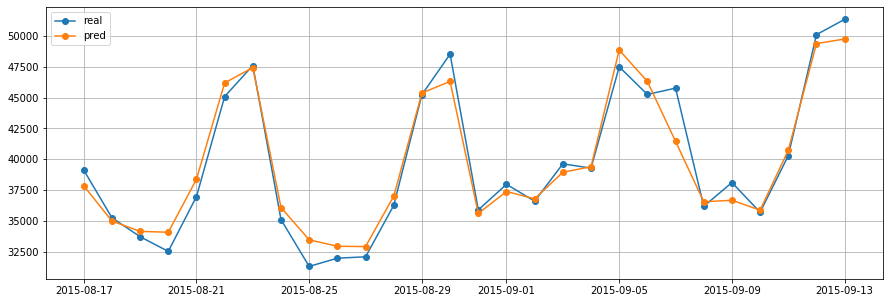

############################################### 6/13 ###############################################
##### Validation period: (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1993.49it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2359.35
[50]	valid_0's rmse: 1884.09
[75]	valid_0's rmse: 1833.16
[100]	valid_0's rmse: 1687.01
[125]	valid_0's rmse: 1525.68
[150]	valid_0's rmse: 1487.49
[175]	valid_0's rmse: 1438.13
[200]	valid_0's rmse: 1442.43
[225]	valid_0's rmse: 1422.5
[250]	valid_0's rmse: 1407.69
[275]	valid_0's rmse: 1356.67
[300]	valid_0's rmse: 1350.96
[325]	valid_0's rmse: 1366.02
[350]	valid_0's rmse: 1380.35
[375]	valid_0's rmse: 1386.67
[400]	valid_0's rmse: 1380.59
[425]	valid_0's rmse: 1385.62
[450]	valid_0's rmse: 1408.8
[475]	valid_0's rmse: 1394.38
[500]	valid_0's rmse: 1371.76
[525]	valid_0's rmse: 1347.41
[550]	valid_0's rmse: 1342.52
[575]	valid_0's rmse: 1361.77
[600]	valid_0's rmse: 1340.71
[625]	valid_0's rmse: 1342.41
[650]	valid_0's rmse: 1331.93
[675]	valid_0's rmse: 1348.32
[700]	valid_0's rmse: 1358.34
[725]	valid_0's rmse: 1369.09
[750]	valid_0's rmse: 1364.04
[775]	valid_0's rmse: 1359.58
[800]	valid_0

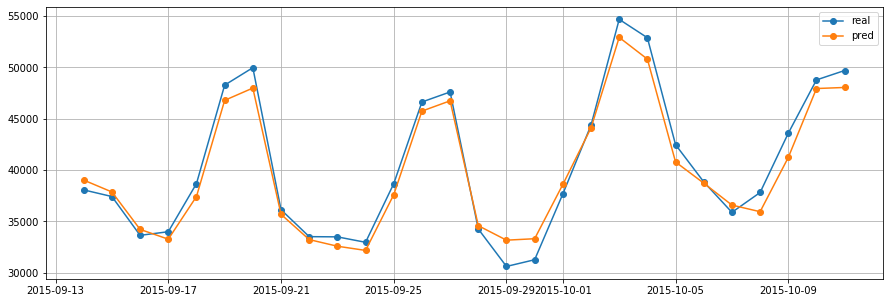

############################################### 7/13 ###############################################
##### Validation period: (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1795.51it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 1661.49
[50]	valid_0's rmse: 1656.31
[75]	valid_0's rmse: 1562.12
[100]	valid_0's rmse: 1507.64
[125]	valid_0's rmse: 1507.13
[150]	valid_0's rmse: 1492.78
[175]	valid_0's rmse: 1430.64
[200]	valid_0's rmse: 1421.69
[225]	valid_0's rmse: 1404.21
[250]	valid_0's rmse: 1391.98
[275]	valid_0's rmse: 1354.41
[300]	valid_0's rmse: 1354.61
[325]	valid_0's rmse: 1371.49
[350]	valid_0's rmse: 1336.07
[375]	valid_0's rmse: 1324.33
[400]	valid_0's rmse: 1332.99
[425]	valid_0's rmse: 1322.14
[450]	valid_0's rmse: 1285.27
[475]	valid_0's rmse: 1292.84
[500]	valid_0's rmse: 1275.66
[525]	valid_0's rmse: 1302.99
[550]	valid_0's rmse: 1306.14
[575]	valid_0's rmse: 1311.37
[600]	valid_0's rmse: 1314.47
[625]	valid_0's rmse: 1302.43
[650]	valid_0's rmse: 1291.67
[675]	valid_0's rmse: 1313.68
[700]	valid_0's rmse: 1312.3
[725]	valid_0's rmse: 1333.07
[750]	valid_0's rmse: 1331.43
[775]	valid_0's rmse: 1360.01
[800]	valid_

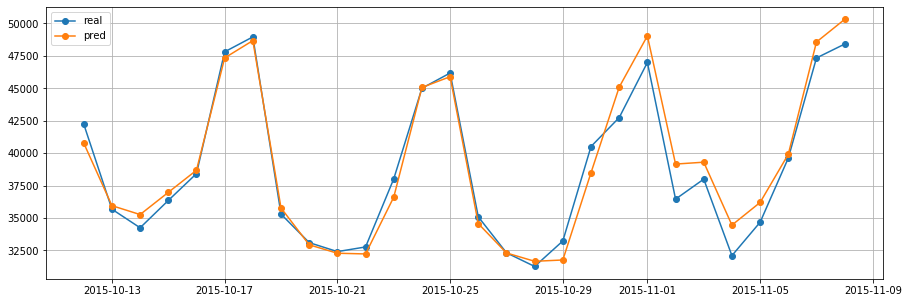

############################################### 8/13 ###############################################
##### Validation period: (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2005.88it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2974.81
[50]	valid_0's rmse: 2170.31
[75]	valid_0's rmse: 1876.67
[100]	valid_0's rmse: 1935.01
[125]	valid_0's rmse: 1827.59
[150]	valid_0's rmse: 1851.87
[175]	valid_0's rmse: 1865.35
[200]	valid_0's rmse: 1846.71
[225]	valid_0's rmse: 1842.82
[250]	valid_0's rmse: 1806.96
[275]	valid_0's rmse: 1810.38
[300]	valid_0's rmse: 1848.61
[325]	valid_0's rmse: 1798.27
[350]	valid_0's rmse: 1806.59
[375]	valid_0's rmse: 1890.02
[400]	valid_0's rmse: 1909.19
[425]	valid_0's rmse: 1877.16
[450]	valid_0's rmse: 1917.51
[475]	valid_0's rmse: 1908
[500]	valid_0's rmse: 1922.04
[525]	valid_0's rmse: 1912.39
[550]	valid_0's rmse: 1898.34
Early stopping, best iteration is:
[265]	valid_0's rmse: 1777.83
RMSE: 1777.8262802619222
RMSSE: 0.30000379119199244


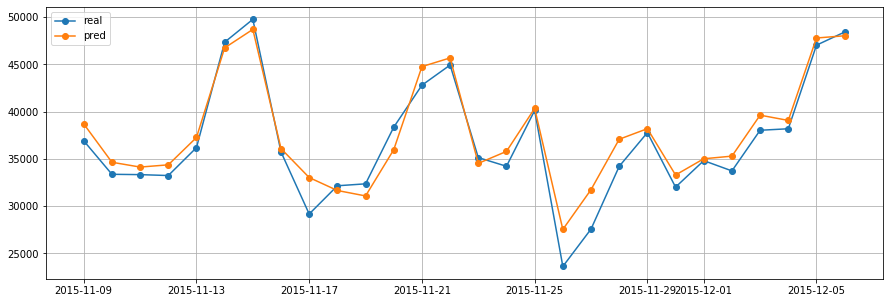

############################################### 9/13 ###############################################
##### Validation period: (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2079.48it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2870.02
[50]	valid_0's rmse: 2557.02
[75]	valid_0's rmse: 2341.96
[100]	valid_0's rmse: 2240.48
[125]	valid_0's rmse: 2142.72
[150]	valid_0's rmse: 1942.09
[175]	valid_0's rmse: 1821.64
[200]	valid_0's rmse: 1843
[225]	valid_0's rmse: 1801.74
[250]	valid_0's rmse: 1759.7
[275]	valid_0's rmse: 1755.23
[300]	valid_0's rmse: 1762.84
[325]	valid_0's rmse: 1720.75
[350]	valid_0's rmse: 1715.36
[375]	valid_0's rmse: 1706.8
[400]	valid_0's rmse: 1694.87
[425]	valid_0's rmse: 1654.17
[450]	valid_0's rmse: 1713.64
[475]	valid_0's rmse: 1749.61
[500]	valid_0's rmse: 1775.34
[525]	valid_0's rmse: 1781.94
[550]	valid_0's rmse: 1800.74
[575]	valid_0's rmse: 1816.85
[600]	valid_0's rmse: 1797.36
[625]	valid_0's rmse: 1818.1
[650]	valid_0's rmse: 1837.94
[675]	valid_0's rmse: 1831.93
[700]	valid_0's rmse: 1827.54
Early stopping, best iteration is:
[417]	valid_0's rmse: 1640.26
RMSE: 1640.2648989225252
RMSSE: 0.27679064

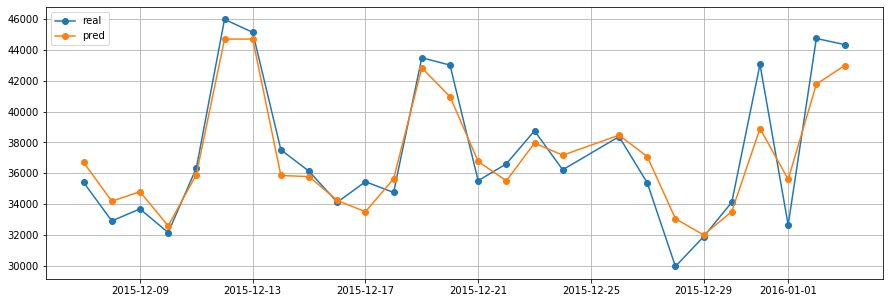

############################################## 10/13 ###############################################
##### Validation period: (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1671.70it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2331.48
[50]	valid_0's rmse: 2034.33
[75]	valid_0's rmse: 2071.91
[100]	valid_0's rmse: 2012.69
[125]	valid_0's rmse: 1928.87
[150]	valid_0's rmse: 1864.62
[175]	valid_0's rmse: 1841.5
[200]	valid_0's rmse: 1824.16
[225]	valid_0's rmse: 1817.68
[250]	valid_0's rmse: 1829.73
[275]	valid_0's rmse: 1868.59
[300]	valid_0's rmse: 1867.92
[325]	valid_0's rmse: 1892.23
[350]	valid_0's rmse: 1950.15
[375]	valid_0's rmse: 1943.56
[400]	valid_0's rmse: 1940.06
[425]	valid_0's rmse: 1964.43
[450]	valid_0's rmse: 1953.69
[475]	valid_0's rmse: 2007.42
Early stopping, best iteration is:
[188]	valid_0's rmse: 1790.81
RMSE: 1790.8137234189844
RMSSE: 0.3021953901284392


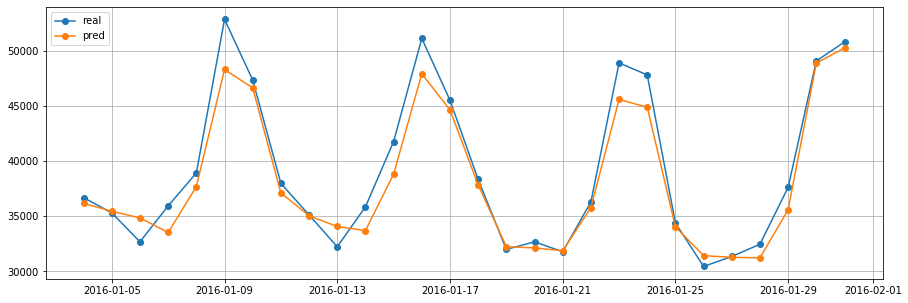

############################################## 11/13 ###############################################
##### Validation period: (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1831.57it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3252.98
[50]	valid_0's rmse: 2888.59
[75]	valid_0's rmse: 2718.52
[100]	valid_0's rmse: 2701.48
[125]	valid_0's rmse: 2698.2
[150]	valid_0's rmse: 2638.09
[175]	valid_0's rmse: 2631.91
[200]	valid_0's rmse: 2688.88
[225]	valid_0's rmse: 2687.15
[250]	valid_0's rmse: 2707.7
[275]	valid_0's rmse: 2777.18
[300]	valid_0's rmse: 2823.46
[325]	valid_0's rmse: 2858.29
[350]	valid_0's rmse: 2898.07
[375]	valid_0's rmse: 2915.5
[400]	valid_0's rmse: 2925.01
[425]	valid_0's rmse: 2960.7
Early stopping, best iteration is:
[141]	valid_0's rmse: 2610.58
RMSE: 2610.5798392663123
RMSSE: 0.4405288962619518


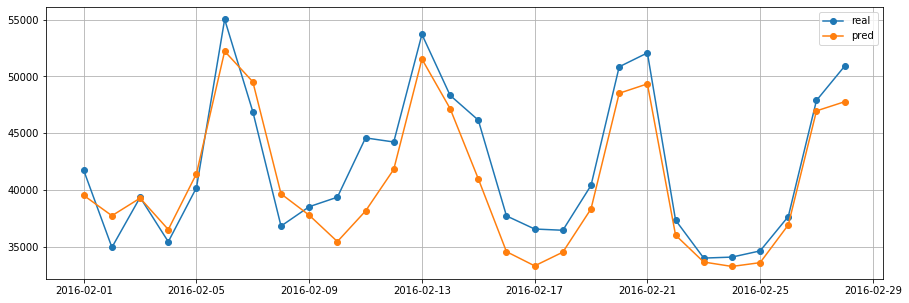

############################################## 12/13 ###############################################
##### Validation period: (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1944.51it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2572.83
[50]	valid_0's rmse: 2296.19
[75]	valid_0's rmse: 2199.98
[100]	valid_0's rmse: 2182.03
[125]	valid_0's rmse: 2164.52
[150]	valid_0's rmse: 2136.68
[175]	valid_0's rmse: 2099.15
[200]	valid_0's rmse: 2082.96
[225]	valid_0's rmse: 2059.69
[250]	valid_0's rmse: 2125.93
[275]	valid_0's rmse: 2129.53
[300]	valid_0's rmse: 2093.16
[325]	valid_0's rmse: 2057
[350]	valid_0's rmse: 2065.56
[375]	valid_0's rmse: 2064.63
[400]	valid_0's rmse: 2051.54
[425]	valid_0's rmse: 2053.1
[450]	valid_0's rmse: 2048.63
[475]	valid_0's rmse: 2046.57
[500]	valid_0's rmse: 2077.71
[525]	valid_0's rmse: 2055.06
[550]	valid_0's rmse: 2058.92
[575]	valid_0's rmse: 2050.12
[600]	valid_0's rmse: 2042.42
[625]	valid_0's rmse: 2020.45
[650]	valid_0's rmse: 2038.83
[675]	valid_0's rmse: 2028.11
[700]	valid_0's rmse: 2019.55
[725]	valid_0's rmse: 1976.42
[750]	valid_0's rmse: 1945.76
[775]	valid_0's rmse: 1940.06
[800]	valid_0's

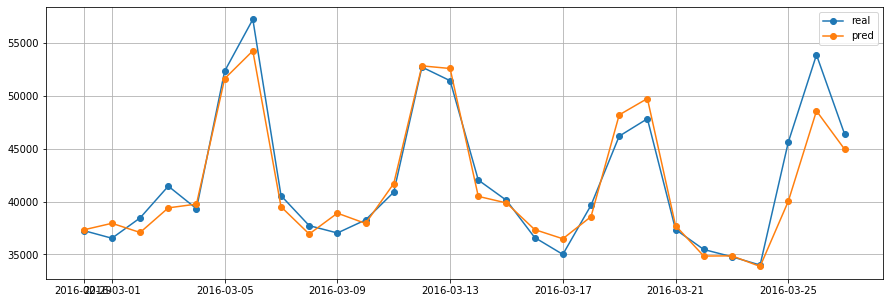

############################################## 13/13 ###############################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2074.33it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2061.88
[50]	valid_0's rmse: 1645.12
[75]	valid_0's rmse: 1463.94
[100]	valid_0's rmse: 1412.33
[125]	valid_0's rmse: 1478.55
[150]	valid_0's rmse: 1603.56
[175]	valid_0's rmse: 1630
[200]	valid_0's rmse: 1569.44
[225]	valid_0's rmse: 1553.79
[250]	valid_0's rmse: 1473.29
[275]	valid_0's rmse: 1476.75
[300]	valid_0's rmse: 1488.44
[325]	valid_0's rmse: 1514.51
[350]	valid_0's rmse: 1509.62
[375]	valid_0's rmse: 1574.75
[400]	valid_0's rmse: 1563.57
Early stopping, best iteration is:
[105]	valid_0's rmse: 1394.03
RMSE: 1394.0325721517095
RMSSE: 0.23523955143076358


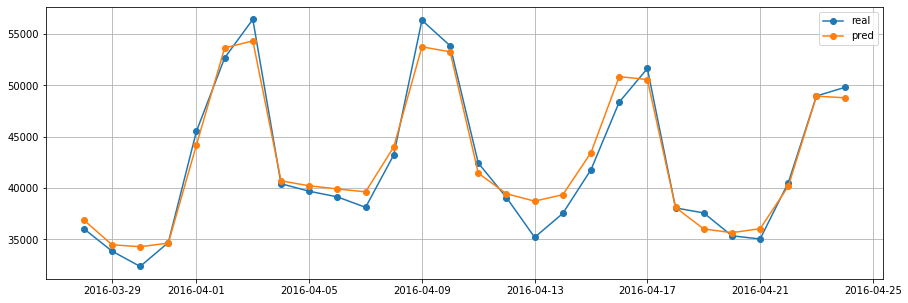

In [11]:
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data, _valid_index)
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})

    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"]/scale_factor)
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])    
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    print(f"RMSE: {errors[-1]*scale_factor}")
    print(f"RMSSE: {errors[-1]}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [12]:
np.mean(np.sort(best_iterations)[1:-1])

542.2727272727273

In [13]:
np.mean(errors)

0.278427188411455

***
### training final models

In [14]:
model_kwargs["model_params"]["num_iterations"] = int(np.mean(np.sort(best_iterations)[1:-1]))
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'rmse',
 'num_iterations': 542,
 'early_stopping_rounds': 300,
 'bagging_freq': 1,
 'seed': 23,
 'learning_rate': 0.19630674759801756,
 'num_leaves': 9,
 'max_bin': 63,
 'feature_fraction': 0.6000000000000001,
 'bagging_fraction': 0.8,
 'min_data_in_leaf': 4,
 'min_gain_to_split': 100000,
 'lambda_l2': 1.4298908229733496}

In [15]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

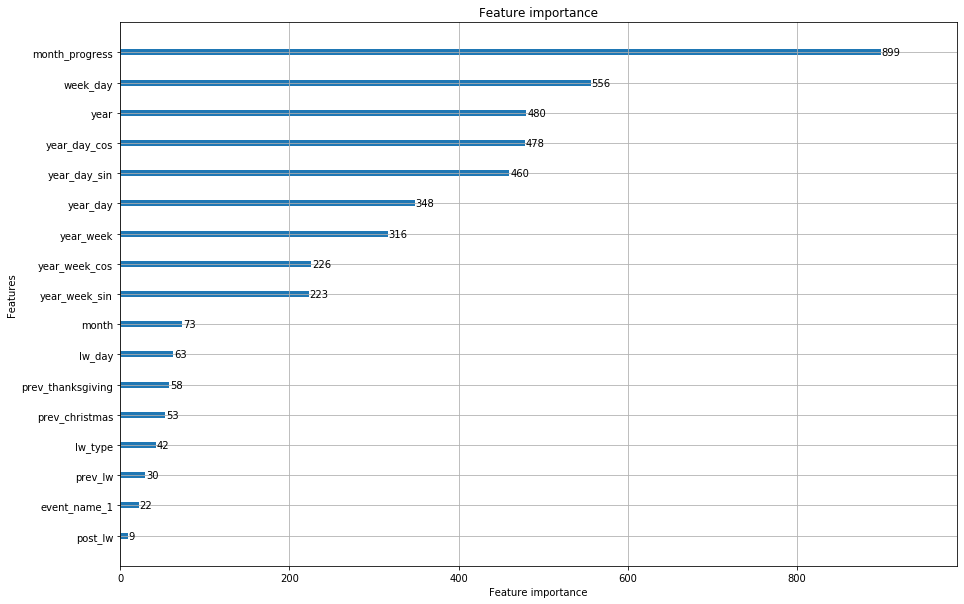

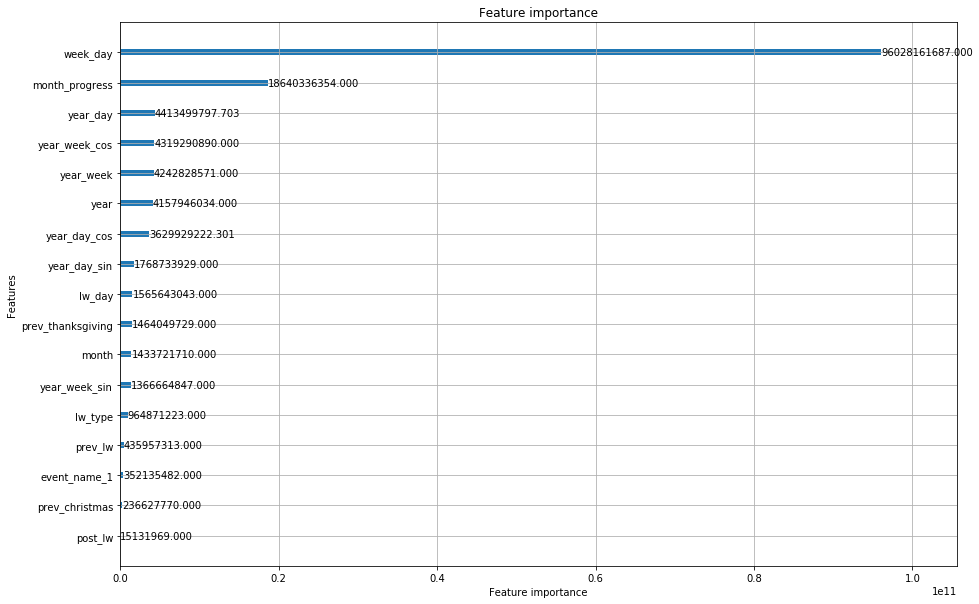

In [16]:
fcaster = all_models[7]
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [48]:
all_predictions = list()
for fcaster in all_models:
    predictions = fcaster.predict(train_data.loc[:, data.columns.drop("y")])
    all_predictions.append(predictions)
predictions = all_predictions[0].copy(deep=True)
predictions["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

In [51]:
residuals = (pd.merge(train_data, predictions, how="inner", on="ds")
             .assign(residual = lambda x: x.y - x.y_pred))
q05 = residuals.residual.quantile(0.05)
q95 = residuals.residual.quantile(0.95)
residuals.query("@q05 < residual < @q95").residual.std()

505.2175813123903

In [52]:
residuals.residual.describe()

count    1908.000000
mean        0.972122
std       682.327522
min     -2873.073260
25%      -428.034317
50%        -7.965273
75%       431.196679
max      3498.149740
Name: residual, dtype: float64

***
### prediction

In [53]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, train_data.columns.drop("y")]
                   .drop_duplicates())
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, train_data.columns.drop("y")]
                  .drop_duplicates())

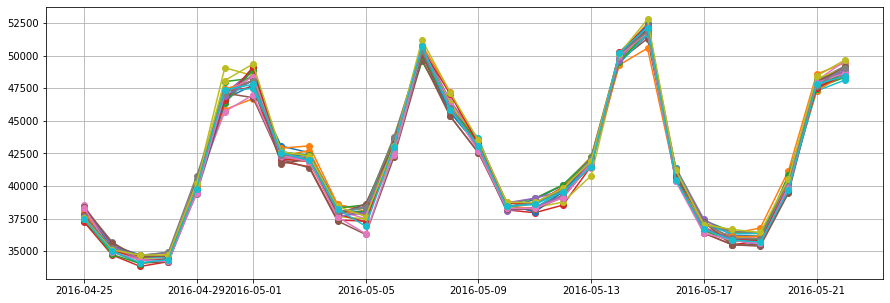

In [54]:
# visualizing the predictions over the validation period
plt.figure(figsize=(15,5))
for i,fcaster in enumerate(all_models):
    _forecast = fcaster.predict(valid_dataframe)    
    plt.plot_date(_forecast.ds, _forecast.y_pred, "o-", label=f"seed: {i}")
plt.grid()
plt.show()

In [55]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [ ]:
forecast.to_csv("../output/forecast_level1-v2.csv", index=False)

***